<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google colab GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue Mar 14 22:50:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    55W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Hyperparameters

In [2]:
# hyperparameters
batch_size = 64 # num independent sequences processed in parallel 
block_size = 256 # maximum context length

dropout = 0.2
learning_rate = 1e-3 #3e-4

# model architecture
n_heads = 6
n_embedding = 384 # each head has dim 64 (=384/6)
n_layer = 1 #6

## Imports

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time

try:
    import einops
except:
    print(f"einops not installed as required, installing...")
    !pip3 install einops
    import einops

from einops import rearrange, reduce, repeat

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"on device: {device}")

on device: cuda


## Downloading and pre-processing data

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)
print(f"\nTrain elements: {len(train_dataset)} | Test elements: {len(test_dataset)}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of size {batch_size}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of size {batch_size}")
xb, yb = next(iter(train_dataloader))
print(xb.shape, yb.shape)

Files already downloaded and verified
Files already downloaded and verified

Train elements: 50000 | Test elements: 10000
Length of train_dataloader: 782 batches of size 64
Length of test_dataloader: 157 batches of size 64
torch.Size([64, 3, 32, 32]) torch.Size([64])


In [6]:
classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
idx_to_class = {class_to_idx[key]:key for key in class_to_idx}
len(classes), classes[:5]

(100, ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver'])

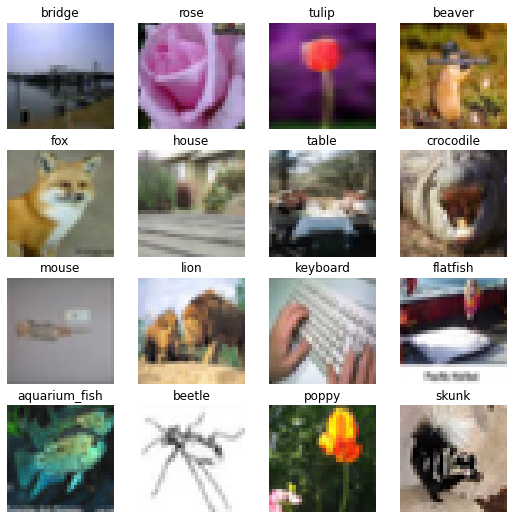

In [7]:
#don't want normalization transform
# train_visual= torchvision.datasets.CIFAR100(root='./data', train=True,
#                                         download=True, transform=transforms.ToTensor())

#Visualizing images(before normalization)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_dataset), size = [1]).item()
  img1, label = train_dataset[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(rearrange(img1, 'c h w -> h w c').numpy())
  plt.title(idx_to_class[label])
  plt.axis(False)

Files already downloaded and verified


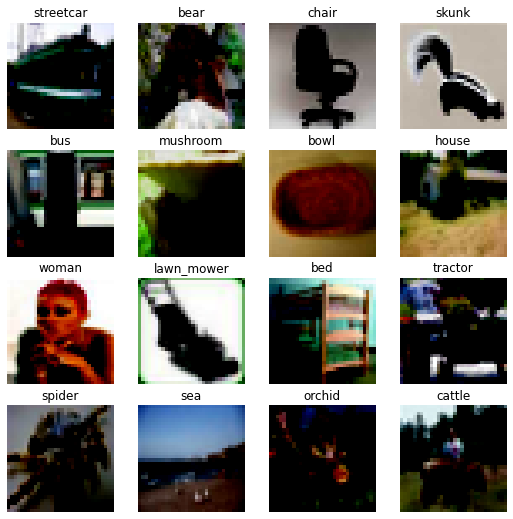

In [8]:
transform_norm = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

norm_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_norm)
#Visualizing images(after normalization)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(norm_dataset), size = [1]).item()
  img2, label = norm_dataset[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(rearrange(img2, 'c h w -> h w c').numpy())
  plt.title(idx_to_class[label])
  plt.axis(False)

In [9]:
print(img1.mean(), img1.std())
print(img2.mean(), img2.std())

tensor(0.5044) tensor(0.2556)
tensor(-0.0757) tensor(0.3874)


In [10]:
def evaluate_model(model: nn.Module, batch_limit=-1) -> dict:
  t_eval = time.time()
  model.eval()
  with torch.inference_mode():
    splits = ['train', 'test']
    categories = ['loss', 'top1', 'top5']
    all = {'train': {c:torch.zeros(len(train_dataloader)) for c in categories}}
    all['test'] = {c: torch.zeros(len(train_dataloader)) for c in categories}
    for split in splits:
      data_loader = train_dataloader if split == 'train' else test_dataloader
      for batch, (xb, yb) in enumerate(data_loader):
        if batch_limit == batch: break
        xb, yb = xb.to(device), yb.to(device)
        logits, loss = model(xb, yb)
        all[split]['loss'][i] = loss.item()
        # top@1 accuracy
        top1_preds = torch.topk(logits, 1, dim = -1).indices.squeeze(dim=-1)
        all[split]['top1'][i] = 100*(torch.sum(top1_preds == yb) / torch.numel(yb)).item()
        # top@5 accuracy
        top5_preds = torch.topk(logits, 5, dim = -1).indices
        y_stretched = repeat(yb, 'b -> b k', k = 5)
        all[split]['top5'][i] = 100*(torch.sum(top5_preds == y_stretched) / torch.numel(yb)).item()
    
  model.train()

  output_dict = {split:list(map(lambda a: round(a.mean().item(), 4), all[split].values())) for split in splits}
  output_dict['eval_time'] = round(time.time()-t_eval, 2)
  return output_dict

In [11]:
def format_output(output_dict, iter, train_time, loss):
  array = [iter,"|"]+output_dict['train']+['|']+output_dict['test']+['|']+[round(train_time,2),output_dict['eval_time'],'|',round(loss.item(),4)]
  title = 'iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)'
  header = "----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------"
  idxs = [0]
  for j in range(len(title)-1): 
    if title[j] == " " and title[j+1] != " ": idxs.append(j+1)
  output_str = ""
  for i in range(len(idxs)): output_str+=" "*(idxs[i]-len(output_str)) + f"{array[i]}"
  if iter == 0: output_str= header + '\n' + title + '\n' + output_str
  return output_str

## Model

In [24]:
class MultiHeadAttention(nn.Module):
  # parallelized attention heads
  
  def __init__(self):
    super().__init__()
    head_size = n_embedding // n_heads
    self.scale_factor = head_size**-0.5 # This scaling factor makes an INSANE difference

    #generating q,k,v for all n_heads at once
    self.qkv_linear = nn.Linear(n_embedding, head_size*n_heads*3) 
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Sequential(
        nn.Linear(head_size*n_heads, n_embedding),
        nn.Dropout(dropout))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    B,T,C = x.shape #[64, 256, 384])
    qkv = self.qkv_linear(x) # [64, 256, 1152]
    q, k, v =  rearrange(qkv, 'b t (qvk h c) -> qvk b h t c', qvk=3, h=n_heads) #torch.Size([3, 64, 6, 256, 64])

    mat_mul = q@rearrange(k, 'b h t c -> b h c t') * self.scale_factor
    mat_mul = nn.functional.softmax(mat_mul, dim = -1)
    mat_mul = self.dropout(mat_mul)
    mat_mul = mat_mul@v
    flattened = rearrange(mat_mul, 'b h t c -> b t (h c)')
    linear = self.linear(flattened)
    return flattened

class FeedFoward(nn.Module):
  def __init__(self):
    super().__init__()
    self.feed_forward = nn.Sequential(
        nn.Linear(n_embedding, 4*n_embedding),
        nn.GELU(),
        nn.Linear(4*n_embedding, n_embedding),
        nn.Dropout(dropout))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.feed_forward(x)

class Transformer(nn.Module):

  def __init__(self):
    super().__init__()
    self.multi_attention = MultiHeadAttention() 
    self.feed_forward = FeedFoward()
    self.ln1 = nn.LayerNorm(n_embedding)
    self.ln2 = nn.LayerNorm(n_embedding)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = x + self.multi_attention(self.ln1(x))
    x = x + self.feed_forward(self.ln2(x))
    return x

class ViT(nn.Module):
  def __init__(self):
      super().__init__()

      self.conv = nn.Conv2d(in_channels=3,
                  out_channels=n_embedding,
                  kernel_size=(2, 2),
                  stride=2)
      self.learnable_embedding = nn.Parameter(torch.randn(n_embedding), requires_grad = True)
      
      self.positional_encoding = nn.Embedding(block_size+1, n_embedding)

      self.transformers = nn.Sequential(*[Transformer() for _ in range(n_layer)])

      self.final_ln = nn.LayerNorm(n_embedding)
      self.final_linear = nn.Linear(n_embedding, len(classes))

  def forward(self, x: torch.Tensor, targets = None) -> torch.Tensor:
    T = block_size + 1
    B = x.shape[0]
    x = rearrange(self.conv(x), 'b c h w -> b (h w) c')
    x = torch.cat((repeat(self.learnable_embedding, 'c -> b () c', b = B), x), dim = 1)
    x = x + self.positional_encoding(torch.arange(T, device = device))

    x = self.transformers(x)

    x = self.final_ln(x)
    logits = self.final_linear(x[:, 0])

    if targets == None:
      loss = None
    else:
      loss = nn.functional.cross_entropy(logits, targets)

    return logits, loss

vit_model = ViT().to(device)
print(f'vit model parameters are on device: {next(vit_model.parameters()).device}')
xb, yb = next(iter(train_dataloader))
xb, yb = xb.to(device), yb.to(device)
logits, loss = vit_model(xb, yb)
print(f"{logits.shape}, {loss.item():.4f}")
print(f"{sum(p.numel() for p in vit_model.parameters())/1e6:.4f} Million Parameters")

vit model parameters are on device: cuda:0
torch.Size([64, 100]), 4.8091
1.9178 Million Parameters


In [25]:

### Training loop
optimizer = torch.optim.AdamW(params = vit_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 200) # T_mult=2

In [26]:
from tqdm import tqdm
losses = []
lrs = []
output_table = []
output_dicts = []


epochs = 100 # training iterations
eval_interval = 10 # after how many batches to print out loss & accuracy

t_train = time.time()
t_train_full = time.time()
print(f"n_heads:{n_heads} | n_embedding: {n_embedding} | n_layer: {n_layer} num_params: {sum(p.numel() for p in vit_model.parameters())/1e6:.4f} Million Parameters")

for epoch in tqdm(range(epochs)):
  for batch, (xb, yb) in enumerate(train_dataloader):
    xb, yb = xb.to(device), yb.to(device)
    logits, loss = vit_model(xb, yb)
    if batch%200 == 0 : print(f'epoch: {epoch} | batch: {batch} | {loss.item():.4f}')
    # if batch % 10 == 0:
    #   train_time = time.time()-t_train
    #   output_dict = evaluate_model(vit_model)
    #   output_dicts.append(output_dict)
    #   formatted = format_output(output_dict, i, train_time, loss)
    #   output_table.append(formatted)
    #   print(formatted)
    #   t_train = time.time()

    losses.append(loss.item())
    lrs.append(scheduler.get_last_lr())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
  scheduler.step()

print(f"\nTime taken for {epochs} epochs: {time.time()-t_train_full:.2f} seconds")
print(f"n_heads:{n_heads} | n_embedding: {n_embedding} | n_layer: {n_layer} num_params: {sum(p.numel() for p in vit_model.parameters())/1e6:.4f} Million Parameters")
for out in output_table: print(out)

n_heads:6 | n_embedding: 384 | n_layer: 1 num_params: 1.9178 Million Parameters


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 0 | batch: 0 | 4.6365
epoch: 0 | batch: 200 | 4.4857
epoch: 0 | batch: 400 | 4.3130
epoch: 0 | batch: 600 | 4.3295


  1%|          | 1/100 [00:16<27:46, 16.83s/it]

epoch: 1 | batch: 0 | 4.1193
epoch: 1 | batch: 200 | 3.9631
epoch: 1 | batch: 400 | 3.9794
epoch: 1 | batch: 600 | 3.7663


  2%|▏         | 2/100 [00:33<27:26, 16.80s/it]

epoch: 2 | batch: 0 | 3.9890
epoch: 2 | batch: 200 | 3.6323
epoch: 2 | batch: 400 | 3.9213
epoch: 2 | batch: 600 | 3.9585


  3%|▎         | 3/100 [00:50<27:05, 16.76s/it]

epoch: 3 | batch: 0 | 3.9340
epoch: 3 | batch: 200 | 3.6461
epoch: 3 | batch: 400 | 3.6065
epoch: 3 | batch: 600 | 3.5147


  4%|▍         | 4/100 [01:07<26:48, 16.76s/it]

epoch: 4 | batch: 0 | 3.6038
epoch: 4 | batch: 200 | 3.6700
epoch: 4 | batch: 400 | 3.4329
epoch: 4 | batch: 600 | 4.0136


  5%|▌         | 5/100 [01:23<26:33, 16.78s/it]

epoch: 5 | batch: 0 | 3.7477
epoch: 5 | batch: 200 | 3.5777


  5%|▌         | 5/100 [01:30<28:34, 18.05s/it]


KeyboardInterrupt: ignored

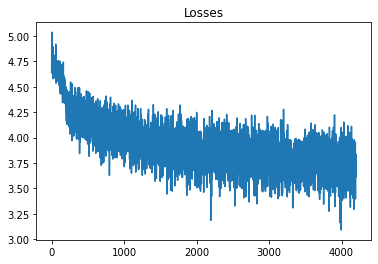

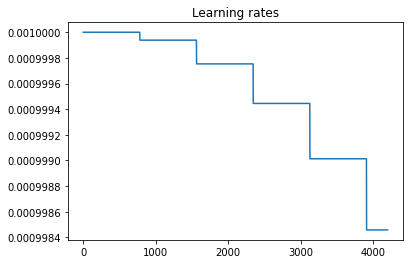

In [27]:
import matplotlib.pyplot as plt


plt.plot(losses)
plt.title("Losses")
plt.show()

plt.plot(lrs)
plt.title("Learning rates")
plt.show()

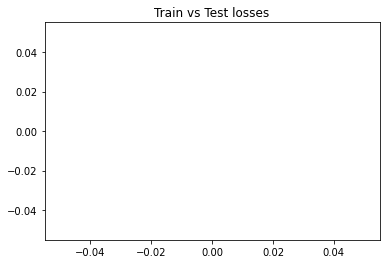

In [28]:
train_losses = []
test_losses = []
for array in output_dicts:
  train_losses.append(array['train'][0])
  test_losses.append(array['test'][0])

import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(test_losses)
plt.title("Train vs Test losses")
plt.show()
